# Graph Building
(Work in progress...)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dgl
import torch

from graph_utils import to_utm, calculate_stations_distance, calculate_graph_structure_dataframe, calculate_features_and_labels, create_graph_structure, print_graph

In [6]:
df = pd.read_csv('../../data/data_initial_preprocessing.csv')
df.shape

(843915, 12)

In [7]:
df

,station_id,lat,long,year,month,day,hour,forecast,gridpp,observation,observation_quality,gridpp_error
0,SN18700,59.9423,10.7200,2019,5,13,12,12.47900,11.25000,11.1,0,0.15000
1,SN80740,66.9035,13.6460,2019,5,13,12,4.09424,6.15000,6.0,0,0.15000
2,SN61630,62.2583,8.2000,2019,5,13,12,1.81200,4.45000,4.3,0,0.15000
3,SN8140,61.4255,11.0803,2019,5,13,12,8.86768,9.65000,9.5,0,0.15000
4,SN23500,61.1220,9.0630,2019,5,13,12,7.61084,9.65860,8.6,0,1.05860
...,...,...,...,...,...,...,...,...,...,...,...,...
843910,SN61580,62.2943,8.1255,2019,5,13,18,2.25586,5.17270,5.8,0,0.62730
843911,SN24670,60.2684,9.6919,2019,5,13,18,9.25342,11.92026,11.0,0,0.92026
843912,SN90490,69.6767,18.9133,2019,5,13,18,3.75146,3.25000,3.1,0,0.15000
843913,SN77490,65.3143,13.4483,2019,5,13,18,-0.56055,-2.15744,-2.6,0,0.44256


In [8]:
stations = df.copy()
stations.drop_duplicates(subset=['station_id'], inplace=True)
stations.shape

(667, 12)

In [9]:
stations

,station_id,lat,long,year,month,day,hour,forecast,gridpp,observation,observation_quality,gridpp_error
0,SN18700,59.94230,10.72000,2019,5,13,12,12.479000,11.25000,11.1,0,0.15000
1,SN80740,66.90350,13.64600,2019,5,13,12,4.094240,6.15000,6.0,0,0.15000
2,SN61630,62.25830,8.20000,2019,5,13,12,1.812000,4.45000,4.3,0,0.15000
3,SN8140,61.42550,11.08030,2019,5,13,12,8.867680,9.65000,9.5,0,0.15000
4,SN23500,61.12200,9.06300,2019,5,13,12,7.610840,9.65860,8.6,0,1.05860
...,...,...,...,...,...,...,...,...,...,...,...,...
324578,SN30244,59.07270,9.92300,2019,10,29,18,0.979500,2.56567,0.7,0,1.86567
325893,SN25541,60.68108,8.00375,2019,10,29,0,-6.306150,-3.95193,-4.5,0,0.54807
388852,SN54815,61.27470,8.13850,2019,11,30,18,-8.348236,-7.62027,-8.0,0,0.37973
556356,SN30428,59.18550,9.54030,2019,1,22,6,-8.286380,-5.60867,-6.0,0,0.39133


In [10]:
stations['utm'] = stations[['lat', 'long']].apply(lambda x: to_utm(x), axis=1)

In [11]:
stations['utm_x'] = stations['utm'].apply(lambda x: x[0])
stations['utm_y'] = stations['utm'].apply(lambda x: x[1])

In [12]:
stations

,station_id,lat,long,year,month,day,hour,forecast,gridpp,observation,observation_quality,gridpp_error,utm,utm_x,utm_y
0,SN18700,59.94230,10.72000,2019,5,13,12,12.479000,11.25000,11.1,0,0.15000,"(596097.435011151, 6646233.876457353, 32, V)",596097.435011,6.646234e+06
1,SN80740,66.90350,13.64600,2019,5,13,12,4.094240,6.15000,6.0,0,0.15000,"(440732.20032325835, 7421266.829027383, 33, W)",440732.200323,7.421267e+06
2,SN61630,62.25830,8.20000,2019,5,13,12,1.812000,4.45000,4.3,0,0.15000,"(458454.11108216754, 6903212.279337059, 32, V)",458454.111082,6.903212e+06
3,SN8140,61.42550,11.08030,2019,5,13,12,8.867680,9.65000,9.5,0,0.15000,"(610993.369200744, 6811952.803180132, 32, V)",610993.369201,6.811953e+06
4,SN23500,61.12200,9.06300,2019,5,13,12,7.610840,9.65860,8.6,0,1.05860,"(503394.33104674995, 6776378.0222047465, 32, V)",503394.331047,6.776378e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324578,SN30244,59.07270,9.92300,2019,10,29,18,0.979500,2.56567,0.7,0,1.86567,"(552915.5778018576, 6548512.881481115, 32, V)",552915.577802,6.548513e+06
325893,SN25541,60.68108,8.00375,2019,10,29,0,-6.306150,-3.95193,-4.5,0,0.54807,"(445579.0407999647, 6727677.984216568, 32, V)",445579.040800,6.727678e+06
388852,SN54815,61.27470,8.13850,2019,11,30,18,-8.348236,-7.62027,-8.0,0,0.37973,"(453808.909393533, 6793689.8468205035, 32, V)",453808.909394,6.793690e+06
556356,SN30428,59.18550,9.54030,2019,1,22,6,-8.286380,-5.60867,-6.0,0,0.39133,"(530874.1403040809, 6560832.869152451, 32, V)",530874.140304,6.560833e+06


In [13]:
x = np.array(stations.utm_x)
y = np.array(stations.utm_y)

In [14]:
x.shape

(667,)

In [15]:
%%time

distances = calculate_stations_distance(x, y)

CPU times: user 9.11 ms, sys: 3.4 ms, total: 12.5 ms
Wall time: 11.3 ms


In [16]:
distances.argsort()[:, :5]

array([[177, 215, 576, 133, 484],
       [579, 657, 244,  45,  20],
       [625, 314, 564, 196, 305],
       ...,
       [179, 265, 506, 228, 233],
       [146, 516,  65, 294, 427],
       [371,  15, 542, 113, 298]])

In [17]:
print(distances[0,177])
print(distances[0,215])
print(distances[0,576])

print('-'*20)

print(distances[1,579])
print(distances[1,657])
print(distances[1,244])

3207.079200729402
3510.8581129298104
3573.3656167363115
--------------------
2627.1202886985902
14043.75675569658
15719.658541234314


In [18]:
edges = calculate_graph_structure_dataframe(distances)
edges

,src,dst,weight
0,0,177,3.207079
1,0,215,3.510858
2,0,576,3.573366
3,0,133,4.361238
4,0,484,4.673445
...,...,...,...
3330,666,371,2.456148
3331,666,15,2.578604
3332,666,542,3.745481
3333,666,113,4.071617


In [19]:
edges.groupby(['src'])['weight'].mean()

src
0       3.865197
1      16.266483
2      25.525325
3      35.266952
4      27.741689
         ...    
662     9.712948
663    25.281873
664    13.636205
665    10.520446
666     4.100726
Name: weight, Length: 667, dtype: float64

Para trazer o conteudo acho que vai ser necessário agrupar todos os dados de cada estação. Vendo a documentação fazer parecer que o caminho vai ser agrupar como vetores multidimensionais. <br><br>Provavel shape <strong>(quantidade de nodes, quantidade de features por entrada, quantidade de entradas por estação)</strong>

Faltaria conferir se existem rows iguais que só trocam src com dst

In [20]:
stations_dict = stations[['station_id']].reset_index(drop=True).to_dict()['station_id']

In [21]:
new_dict = dict([(value, key) for key, value in stations_dict.items()])

In [22]:
df['node'] = df.station_id.apply(lambda x: new_dict[x])

In [23]:
df.columns

Index(['station_id', 'lat', 'long', 'year', 'month', 'day', 'hour', 'forecast',
       'gridpp', 'observation', 'observation_quality', 'gridpp_error', 'node'],
      dtype='object')

In [31]:
missing_analysis = df.groupby(['node']).count()['station_id'].copy()
missing_analysis

node
0      1392
1      1392
2      1381
3      1387
4      1383
       ... 
662      37
663     223
664     469
665      74
666       1
Name: station_id, Length: 667, dtype: int64

In [38]:
missing_analysis[missing_analysis > limite]

node
0      1392
1      1392
2      1381
3      1387
4      1383
       ... 
630    1393
631    1388
632    1310
634    1353
639    1333
Name: station_id, Length: 507, dtype: int64

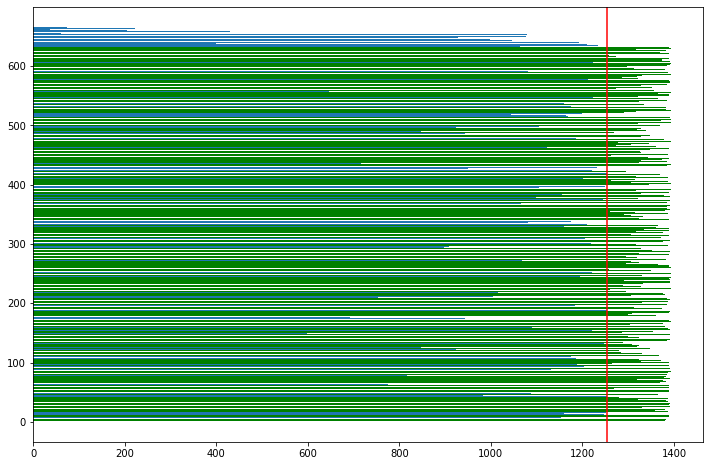

In [39]:
limite = missing_analysis.max()*0.9

plt.figure(figsize=(12,8))
plt.barh(missing_analysis[missing_analysis > limite].index, missing_analysis[missing_analysis > limite], color='green')
plt.barh(missing_analysis[missing_analysis < limite].index, missing_analysis[missing_analysis < limite])
plt.axvline(limite, color='red')
plt.show()

In [41]:
print(f'{missing_analysis[missing_analysis > limite].shape[0]/missing_analysis.shape[0]}% of data has less than 10% missing values')

0.760119940029985% of data has less than 10% missing values


In [22]:
df.groupby(['node']).count()['station_id'].max()

1393

In [20]:
features_columns = ['lat', 'long', 'year', 'month', 'day', 'hour', 'forecast',
       'gridpp']
label_column = ['observation']

In [21]:
%%time
features, labels = calculate_features_and_labels(df, 1400, x.shape[0], features_columns, label_column)

CPU times: user 2.96 s, sys: 0 ns, total: 2.96 s
Wall time: 2.96 s


In [24]:
graph = create_graph_structure(edges)

In [25]:
graph

Graph(num_nodes=667, num_edges=3335,
      ndata_schemes={}
      edata_schemes={})

In [26]:
graph.ndata['x'] = torch.from_numpy(features)
graph.ndata['y'] = torch.from_numpy(labels)


In [27]:
graph

Graph(num_nodes=667, num_edges=3335,
      ndata_schemes={'x': Scheme(shape=(1400, 8), dtype=torch.float64), 'y': Scheme(shape=(1400,), dtype=torch.float64)}
      edata_schemes={})

In [ ]:
# class WeatherDataset(dgl.data.DGLDataset):
#     def __init__(self):
#         super().__init__(name='weather_dataset')
#
#     def process(self):
#         nodes_data = pd.read_csv('members.csv')
#         edges_data = pd.read_csv('interactions.csv')
#         node_features = torch.from_numpy(nodes_data['Age'].to_numpy())
#         node_labels = torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy())
#         edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
#         edges_src = torch.from_numpy(edges_data['Src'].to_numpy())
#         edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())
#
#         self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
#         self.graph.ndata['feat'] = node_features
#         self.graph.ndata['label'] = node_labels
#         self.graph.edata['weight'] = edge_features
#
#         # If your dataset is a node classification dataset, you will need to assign
#         # masks indicating whether a node belongs to training, validation, and test set.
#         n_nodes = nodes_data.shape[0]
#         n_train = int(n_nodes * 0.6)
#         n_val = int(n_nodes * 0.2)
#         train_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         val_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         train_mask[:n_train] = True
#         val_mask[n_train:n_train + n_val] = True
#         test_mask[n_train + n_val:] = True
#         self.graph.ndata['train_mask'] = train_mask
#         self.graph.ndata['val_mask'] = val_mask
#         self.graph.ndata['test_mask'] = test_mask
#
#     def __getitem__(self, i):
#         return self.graph
#
#     def __len__(self):
#         return 1
